# Exercise 8 - Muscle synergies, part I

## Load signal `E08_signal`, angle reference `E08_angle`, and D08 synergies `D09_W.csv`

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from sklearn.decomposition import NMF
from scipy.interpolate import interp1d

data = pd.read_csv('../signals/E08_signal.csv').values
angle = pd.read_csv('../signals/E08_angle.csv').values
W_temp = pd.read_csv('../signals/D09_W.csv').values

n_muscles = data.shape[1]

## Visualize raw emg and extract normalized envelope

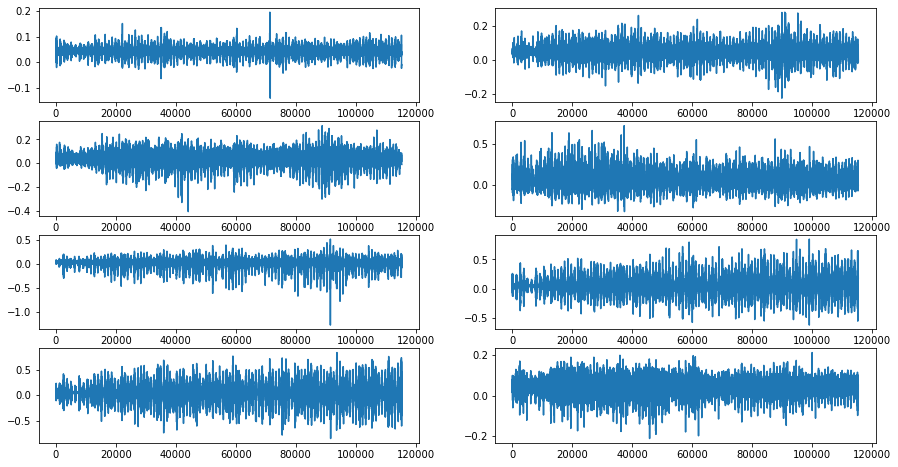

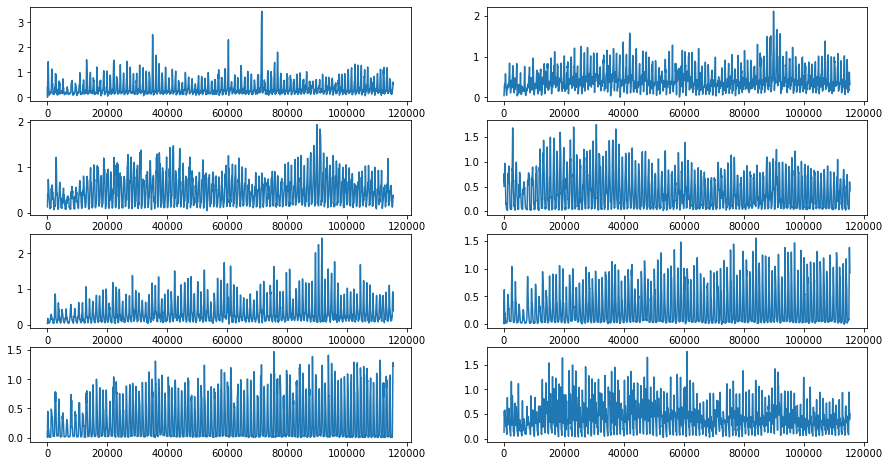

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(data[:,i])
plt.show()

bp = [25, 450]
fs = 1000

b, a = butter(3, [x/fs for x in bp], btype='bandpass')

data_filt = filtfilt(b, a, data, axis=0)

bs = [49.5, 50.5]

b, a = butter(3, [x/fs for x in bs], btype='bandstop')

data_filt = filtfilt(b, a, data_filt, axis=0)

fc = 10
fs = 1000

b, a = butter(3, fc/fs, btype='lowpass')

env = filtfilt(b, a, np.abs(data_filt), axis=0)

env = np.abs(env)

pk_locs = find_peaks(angle.squeeze(), height= 5, distance = 500)[0]
pk_locs = pk_locs[pk_locs > 5000]

pk_values = []
for i0, i1 in zip(pk_locs[:-1], pk_locs[1:]):
    pk_values.append(np.max(env[i0:i1,:], axis=0)) 
pk_values = np.asarray(pk_values)
norm_factors = np.median(pk_values, axis=0)
env_norm = np.asarray([env[:,i]/norm_factors[i] for i in range(n_muscles)]).transpose()

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(env_norm[:,i])
plt.show()

## Test the loaded W on this signal

In [15]:
def VAF(true_data, rec_data):

    return 1 - np.sum((true_data.flatten() - rec_data.flatten())**2)/np.sum(rec_data.flatten()**2)

def nnr(data_in, w_in, max_iter, tol):
    if data_in.shape[1]<data_in.shape[0]:
        data_in = data_in.transpose()
    if w_in.shape[0]<w_in.shape[1]:
        w_in = w_in.transpose()
    c = 0
    convergence = False
    err = []
    h = np.random.rand(w_in.shape[1], data_in.shape[1])
    while c<max_iter:
        num = w_in.transpose()@data_in
        den = w_in.transpose()@w_in@h
        h *= num/den
        err.append(np.sqrt(np.sum((data_in.flatten() - (w_in@h).flatten())**2)))

        if c>10:
            if np.abs(err[-10] - err[-1]) < tol:
                c=max_iter
                convergence = True
        c += 1

    if not convergence:
        print('Algorithm did not converge')
        
    return h

In [16]:
max_iter = 2000
tol = 1e-6
h_rec = nnr(env, W_temp, max_iter, tol)

vaf_rec = VAF(env.transpose(), W_temp@h_rec)
print(f'Reconstruction VAF: {vaf_rec:.4f}')

Reconstruction VAF: 0.8336


(50,)


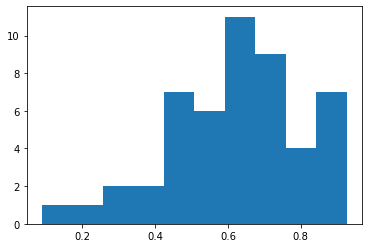

95th percentile: 0.8954


In [17]:
n_random = 50
w_rand = W_temp.copy()

vaf_rand = []
for i in range(n_random):
    np.random.shuffle(w_rand)
    h_rand = nnr(env, w_rand, max_iter, tol)
    vaf_rand.append(VAF(env.transpose(), w_rand@h_rand))
vaf_rand = np.asarray(vaf_rand)
print(vaf_rand.shape)

plt.figure()
plt.hist(vaf_rand)
plt.show()

print(f'95th percentile: {np.percentile(vaf_rand, 95):.4f}')

## Extract synergies

In [18]:
nmf_options = {
    'solver': 'mu',
    'max_iter': 500,
    'init': 'random'
}
W = []
H = []
rec = []
VAF_tot = []
for i in range(1,n_muscles+1):
    nmf = NMF(n_components=i, **nmf_options)
    H.append(nmf.fit_transform(env).transpose())
    W.append(nmf.components_.transpose())
    rec.append((W[-1]@H[-1]).transpose())
    VAF_tot.append(VAF(env, rec[-1]))

c:\programdata\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\programdata\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\programdata\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


## Normalize H and H_rec

In [27]:
n_syn = 4
H_sel = H[n_syn-1]
W_sel = W[n_syn-1]
n_points = 360
H_norm = []
H_rec_norm = []

for i0, i1 in zip(pk_locs[:-1], pk_locs[1:]):
    H_norm.append(
        interp1d(
            np.linspace(i0, i1, i1-i0).transpose(),
            H_sel[:,i0:i1],
            axis=1
        )(np.linspace(i0, i1, n_points))
    )
    H_rec_norm.append(
        interp1d(
            np.linspace(i0, i1, i1-i0).transpose(),
            h_rec[:,i0:i1],
            axis=1
        )(np.linspace(i0, i1, n_points))
    )
    

H_norm = np.asarray(H_norm)
H_norm=np.mean(H_norm, axis=0).squeeze()
H_rec_norm = np.asarray(H_rec_norm)
H_rec_norm=np.mean(H_rec_norm, axis=0).squeeze()
print(H_norm.shape)
print(H_rec_norm.shape)

(4, 360)
(4, 360)


## Compare H and H_rec

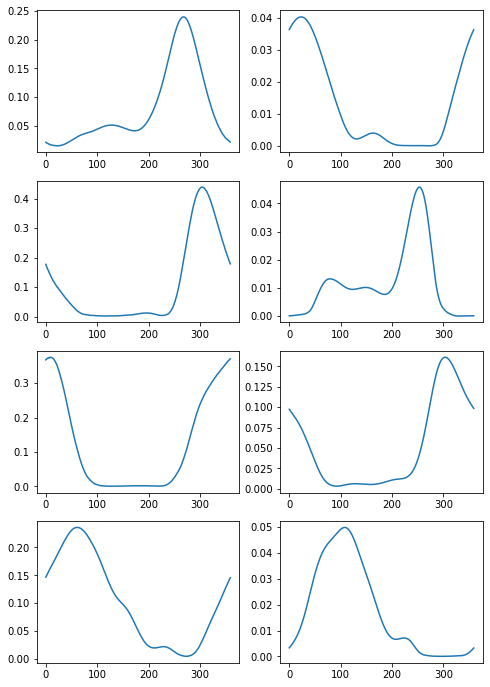

In [28]:
fig,ax = plt.subplots(4,2,figsize=(8,12))
for i in range(n_syn):
    ax[i,0].plot(H_norm[i,:])
    ax[i,1].plot(H_rec_norm[i,:])